# Unsupervised Learning

## K-Means

Train K-Means clusterer on the blobs datasets

In [1]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import numpy as np

blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

k = 5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
y_pred = kmeans.fit_predict(X)

In [2]:
# KMeans instance preserves the predicted labels of the instances it was trained on
print(y_pred)
print(y_pred is kmeans.labels_)

[0 0 4 ... 3 1 0]
True


In [3]:
# see the 5 centroids
kmeans.cluster_centers_

array([[-2.80214068,  1.55162671],
       [ 0.08703534,  2.58438091],
       [-1.46869323,  2.28214236],
       [-2.79290307,  2.79641063],
       [ 0.31332823,  1.96822352]])

We can easily assign new instances to the cluster whose centroid is closest:

In [4]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([4, 4, 3, 3], dtype=int32)

In the KMeans class, the
transform() method measures the distance from each instance to every
centroid:

In [5]:
kmeans.transform(X_new).round(2)

array([[2.84, 0.59, 1.5 , 2.9 , 0.31],
       [5.82, 2.97, 4.48, 5.85, 2.69],
       [1.46, 3.11, 1.69, 0.29, 3.47],
       [0.97, 3.09, 1.55, 0.36, 3.36]])

If you happen to know approximately where the centroids should be (e.g., if
you ran another clustering algorithm earlier), then you can set the init
hyperparameter to a NumPy array containing the list of centroids, and set
n_init to 1:

In [6]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)

,n_clusters,5
,init,"array([[-3, ... [ 0, 2]])"
,n_init,1
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


Another solution is to run the algorithm multiple times with different
random initializations and keep the best solution.

Performance metric: inertia. It is the sum of the squared distances between the instances and their closest centroids.

In [7]:
# see model's inertia
kmeans.inertia_

211.5985372581684

In [8]:
# score method returns a negative inertia
kmeans.score(X)

-211.59853725816842

Use scikit-learn's mini batch K-Means:

In [9]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

,n_clusters,5
,init,'k-means++'
,max_iter,100
,batch_size,1024
,verbose,0
,compute_labels,True
,random_state,42
,tol,0.0
,max_no_improvement,10
,init_size,None
,n_init,'auto'


In [10]:
# compute silhouette score
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.655517642572828

### Using Clustering for Image Segmentation

In [11]:
from PIL import Image

image = np.asarray(Image.open("ladybug.png"))
image.shape

(533, 800, 3)

In [12]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

### Using Clustering for Semi-Supervised Learning

Semi-supervised learning: when we have plenty of unlabeled instances and very few labeled instances

load digits dataset, which is a simple MNIST-like dataset
containing 1,797 grayscale 8 × 8 images representing the digits 0 to 9:

In [13]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

We will pretend we only have labels for 50 instances. To get a baseline
performance, let’s train a logistic regression model on these 50 labeled
instances:

In [14]:
from sklearn.linear_model import LogisticRegression

n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


We can then measure the accuracy of this model on the test set (note that
the test set must be labeled):

In [15]:
log_reg.score(X_test, y_test)

0.7581863979848866

Let’s cluster the
training set into 50 clusters. Then, for each cluster, we’ll find the image
closest to the centroid. We’ll call these images the representative images:

In [16]:
k = 50
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Now let's plot these representative images and label them manually:

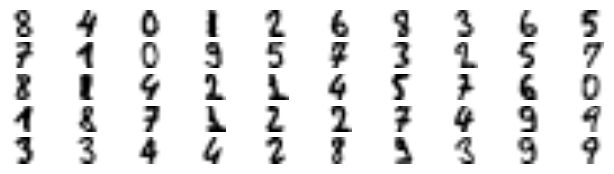

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(5, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8,8), cmap="binary",
               interpolation="bilinear")
    plt.axis("off")

plt.show()

In [18]:
y_representative_digits = np.array([
    8, 4, 0, 1, 2, 6, 8, 3, 6, 5,
    7, 1, 0, 9, 5, 7, 3, 2, 5, 7,
    8, 1, 4, 2, 1, 4, 5, 7, 6, 0,
    1, 8, 7, 1, 2, 2, 7, 4, 9, 9,
    3, 3, 4, 4, 2, 8, 9, 3, 9, 9,
])

Now we have a dataset with just 50 labeled instances, but instead of being
random instances, each of them is a representative image of its cluster. Let’s
see if the performance is any better:

In [19]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8614609571788413

what if we propagated the labels to
all the other instances in the same cluster? This is called label propagation:

In [20]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

Now let’s train the model again and look at its performance:

In [21]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.853904282115869

Compared to fully supervised learning:

In [22]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.9093198992443325

Let’s see if we can do even
better by ignoring the 1% of instances that are farthest from their cluster
center: this should eliminate some outliers

In [23]:
percentile_closest = 99

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_== i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

Now let’s train the model again on this partially propagated dataset and see
what accuracy we get:

In [24]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.853904282115869

Yikes... label propagation and eliminating outliers did not help here. In the author's code, both techniques actually improved the model's performance to actually better than if it was supervised.

propagated labels are actually pretty good:

In [25]:
(y_train_partially_propagated == y_train[partially_propagated]).mean()

np.float64(0.9577777777777777)

## DBSCAN

Test it on the moons dataset:

In [26]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05)
dbscan = DBSCAN(eps=0.20, min_samples=5)
dbscan.fit(X)

,eps,0.2
,min_samples,5
,metric,'euclidean'
,metric_params,None
,algorithm,'auto'
,leaf_size,30
,p,None
,n_jobs,None


In [27]:
# the labels are available in the labels_ instance variable:
dbscan.labels_[:10]

array([0, 1, 1, 1, 1, 0, 0, 1, 0, 0])

In [28]:
# see indices of the core instances
dbscan.core_sample_indices_[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [29]:
# see core instances
dbscan.components_[:10]

array([[ 2.04252751,  0.3298421 ],
       [-0.61852905,  0.74826818],
       [-0.9022177 ,  0.38327046],
       [-0.33259547,  0.83377579],
       [-0.83562576,  0.40229231],
       [-0.01727028,  0.285298  ],
       [ 0.19924736, -0.09675015],
       [ 0.32434561,  0.90298691],
       [ 1.71557588, -0.27293814],
       [ 1.7837846 , -0.04112171]])

DBSCAN class does not have a predict() method. This decision was made because different
classification algorithms can be better for different tasks, so the authors
decided to let the user choose which one to use. Moreover, it’s not hard to
implement. For example, let’s train a KNeighborsClassifier:

In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

,n_neighbors,50
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


Now, given a few new instances, we can predict which clusters they most
likely belong to and even estimate a probability for each cluster:

In [31]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
print(knn.predict(X_new))
knn.predict_proba(X_new)

[1 0 1 0]


array([[0.14, 0.86],
       [1.  , 0.  ],
       [0.2 , 0.8 ],
       [1.  , 0.  ]])

It is fairly straightforward to introduce a maximum distance, in
which case the two instances (in X_new) that are far away from both clusters are
classified as anomalies. To do this, use the kneighbors() method of the
KNeighborsClassifier. Given a set of instances, it returns the distances
and the indices of the k-nearest neighbors in the training set(two matrices,
each with k columns):

In [32]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

## Gaussian Mixtures

creating dataset:

In [33]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Scikit-Learn’s GaussianMixture is very simple:

In [34]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

,n_components,3
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,10
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


Let’s look at the parameters that the algorithm estimated:

In [35]:
gm.weights_

array([0.40005972, 0.20961444, 0.39032584])

In [36]:
gm.means_

array([[-1.40764129,  1.42712848],
       [ 3.39947665,  1.05931088],
       [ 0.05145113,  0.07534576]])

In [37]:
gm.covariances_

array([[[ 0.63478217,  0.72970097],
        [ 0.72970097,  1.16094925]],

       [[ 1.14740131, -0.03271106],
        [-0.03271106,  0.95498333]],

       [[ 0.68825143,  0.79617956],
        [ 0.79617956,  1.21242183]]])

You can check whether or not the algorithm converged and how many
iterations it took:

In [38]:
print(gm.converged_)
print(gm.n_iter_)

True
4


use the predict()
method for hard clustering, or the predict_proba() method for soft
clustering:

In [39]:
print(gm.predict(X), "\n")
print(gm.predict_proba(X).round(3))

[2 2 0 ... 1 1 1] 

[[0.    0.023 0.977]
 [0.001 0.016 0.983]
 [1.    0.    0.   ]
 ...
 [0.    1.    0.   ]
 [0.    1.    0.   ]
 [0.    1.    0.   ]]


A Gaussian mixture model is a generative model, meaning you can sample
new instances from it (note that they are ordered by cluster index):

In [40]:
X_new, y_new = gm.sample(6)
X_new

array([[-2.32491052,  1.04752548],
       [-1.16654983,  1.62795173],
       [ 1.84860618,  2.07374016],
       [ 3.98304484,  1.49869936],
       [ 3.8163406 ,  0.53038367],
       [ 0.38079484, -0.56239369]])

In [41]:
y_new

array([0, 0, 1, 1, 1, 2])

It is also possible to estimate the density of the model at any given location.
This is achieved using the score_samples() method: for each instance it is
given, this method estimates the log of the probability density function
(PDF) at that location. The greater the score, the higher the density:

In [42]:
gm.score_samples(X).round(2)

array([-2.61, -3.57, -3.33, ..., -3.51, -4.4 , -3.81], shape=(1250,))

These are not probabilities, but
probability densities

### **Using Gaussian Mixtures for Anomaly Detection**

Gaussian Mixtures can be used for anomaly detection: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 2%, then you can set the density threshold to be the value that results in having 2% of the instances located in areas below that threshold density:

In [43]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 2)
anomalies = X[densities < density_threshold]

### **Selecting the Number of Clusters**

With k-means, you can use the inertia or the silhouette score to select the
appropriate number of clusters. But with Gaussian mixtures, it is not
possible to use these metrics because they are not reliable when the clusters
are not spherical or have different sizes. Instead, you can try to find the
model that minimizes a theoretical information criterion, such as the
Bayesian information criterion (BIC) or the Akaike information criterion
(AIC)

To compute the BIC and AIC, call the bic() and aic() methods:

In [44]:
gm.bic(X)

np.float64(8189.733705221638)

In [45]:
gm.aic(X)

np.float64(8102.5084251066)

### **Bayesian Gaussian Mixture Models**

Rather than manually searching for the optimal number of clusters, you can
use the BayesianGaussianMixture class, which is capable of giving
weights equal (or close) to zero to unnecessary clusters. Set the number of
clusters n_components to a value that you have good reason to believe is
greater than the optimal number of clusters (this assumes some minimal
knowledge about the problem at hand), and the algorithm will eliminate the
unnecessary clusters automatically. For example, let’s set the number of
clusters to 10 and see what happens:

In [46]:
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42,
                              max_iter=1000)
bgm.fit(X)
bgm.weights_.round(2)

array([0.4 , 0.21, 0.39, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

# Coding Questions

## 10.
The classic Olivetti faces dataset contains 400 grayscale 64 × 64–pixel
images of faces. Each image is flattened to a 1D vector of size 4,096.
Forty different people were photographed (10 times each), and the
usual task is to train a model that can predict which person is
represented in each picture. Load the dataset using the
sklearn.datasets.fetch_olivetti_faces() function, then split it
into a training set, a validation set, and a test set (note that the dataset
is already scaled between 0 and 1). Since the dataset is quite small, you
will probably want to use stratified sampling to ensure that there are
the same number of images per person in each set. Next, cluster the
images using k-means, and ensure that you have a good number of clusters (using one of the techniques discussed in this chapter).
Visualize the clusters: do you see similar faces in each cluster?

In [47]:
# loading dataset
from sklearn.datasets import fetch_olivetti_faces
X, y = fetch_olivetti_faces(return_X_y=True)

X.shape

(400, 4096)

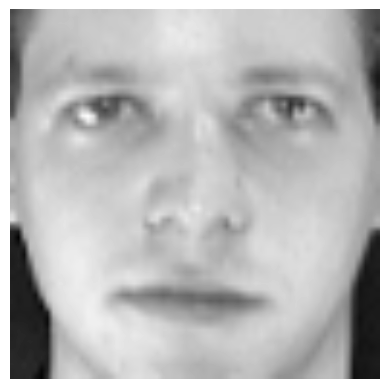

In [48]:
# finding out how to plot the images 
plt.imshow(X[0].reshape(64,64), cmap=plt.cm.gray, interpolation="bilinear")
plt.axis("off")
plt.show()

In [49]:
# see labels 
y_train[:40]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 5, 5, 6, 5, 0, 9, 8, 9])

In [50]:
from sklearn.model_selection import train_test_split

# splitting train and validation sets from test set. Test set has 80 instances
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(np.unique_counts(y_test).counts) # just checking if datasets are stratified

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2]


In [51]:
# splitting train and validation sets. Train set has 280 instances and Validation set has 40
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, train_size=280, random_state=42, stratify=y_train_valid)

In [52]:
# function for trying a lot of values for n_clusters. k_range is range of clusters the function will train with.
# Also return inertia and silhouette scores for all values of n_clusters trained
def get_inertia_silhouette_score(k, random_state=None):        
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=random_state)
    kmeans.fit(X_train)

    return kmeans.inertia_, silhouette_score(X_train, kmeans.labels_)

In [53]:
# plot
def plot_inertia_silhouette_scores(k_range, scores, figsize):
    fig, axs = plt.subplots(1,2,figsize=figsize)
    titles = ["Inertia", "Silhouette Score"]
    
    for i in range(2):
        ax = axs[i]
        ax.plot(k_range, scores[:, i], "o-")
        ax.grid("off")
        ax.set_title(titles[i])
        ax.set_xlim(k_range[0], k_range[-1])
    
    plt.show()

In [54]:
%%time
# try this range since 40 is the number of classes
from joblib import Parallel, delayed
k_range = range(20,61)
scores = np.array(Parallel(n_jobs=-1)(delayed(get_inertia_silhouette_score)(k, 42) for k in k_range))

CPU times: total: 828 ms
Wall time: 52.1 s


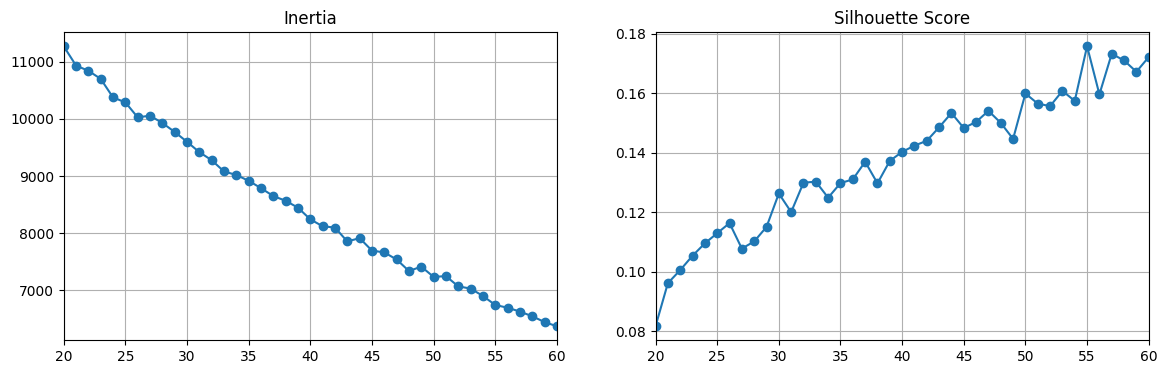

In [55]:
plot_inertia_silhouette_scores(k_range, scores, (14,4))

In [56]:
%%time
# It seems the elbow point
k_range = range(61, 101)
scores = np.array(Parallel(n_jobs=-1)(delayed(get_inertia_silhouette_score)(k, 42) for k in k_range))

CPU times: total: 1.73 s
Wall time: 1min 36s


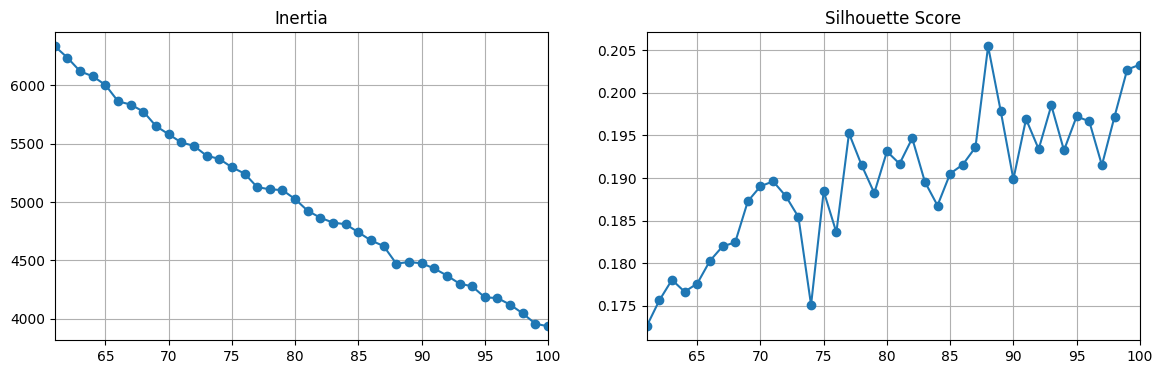

In [57]:
plot_inertia_silhouette_scores(k_range, scores, (14,4))

Both the elbow point and highest silhouette score were found!
* Elbow point: 88 clusters
* Best silhouette score: 88 clusters

**88 clusters** for both!

In [58]:
kmeans = KMeans(n_clusters=88, n_init=10, random_state=42)
kmeans.fit(X_train)

,n_clusters,88
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [59]:
# see how many data instances each cluster contains at most
np.unique_counts(kmeans.labels_).counts.max()

np.int64(9)

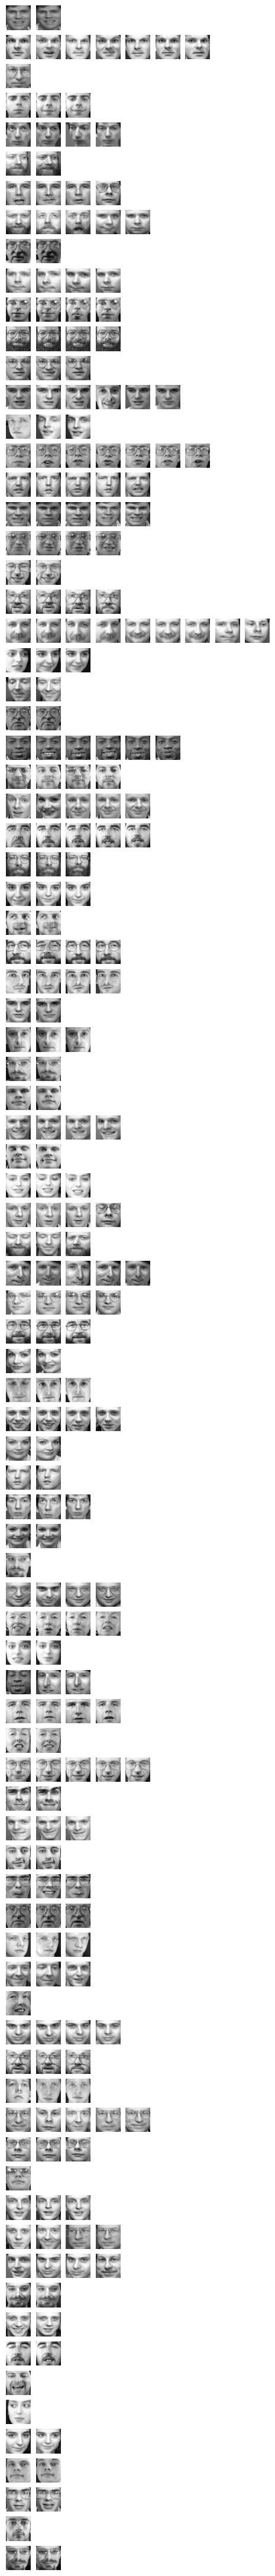

In [60]:
# plot all clusters separated by row
sorted_indices = np.argsort(kmeans.labels_)
plt.figure(figsize=(0.64*9, 0.64*88))
current_label = 0
subplot_i = 0
for sorted_i in sorted_indices:
    new_label = kmeans.labels_[sorted_i] 
    modulus = subplot_i % 9
    if new_label != current_label and modulus:
        subplot_i += 10 - modulus
    else:
        subplot_i += 1
    current_label = new_label
    plt.subplot(88, 9, subplot_i)
    plt.imshow(X_train[sorted_i].reshape(64,64), cmap=plt.cm.gray, interpolation="bilinear")
    plt.axis("off")
        
plt.show()

Most of the clusters have similar faces in them 😃

## 11.
Continuing with the Olivetti faces dataset, train a classifier to predict
which person is represented in each picture, and evaluate it on the
validation set. Next, use k-means as a dimensionality reduction tool,
and train a classifier on the reduced set. Search for the number of
clusters that allows the classifier to get the best performance: what
performance can you reach? What if you append the features from the
reduced set to the original features (again, searching for the best
number of clusters)?

The classifier learning algorithm I am going to use is Extremely Randomized Trees

In [61]:
from sklearn.ensemble import ExtraTreesClassifier
import warnings

warnings.filterwarnings("ignore")

extra = ExtraTreesClassifier(random_state=42,n_jobs=-1)
extra.fit(X_train, y_train)
extra.score(X_valid, y_valid)

0.95

Score achieved without any hyperparameter tuning is 0.95

Now I am going to do grid search and find the n_clusters value that gives the best accuracy. Searching from 40 to 100 clusters.

In [62]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
extra = make_pipeline(KMeans(random_state=42, n_init=10), ExtraTreesClassifier(random_state=42))
grid = {"kmeans__n_clusters": range(40,101)}

gridsearch = GridSearchCV(extra, grid, cv=3, n_jobs=-1)
gridsearch.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'kmeans__n_clusters': range(40, 101)}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_clusters,88


In [63]:
print(gridsearch.best_params_)
gridsearch.score(X_valid, y_valid)

{'kmeans__n_clusters': 88}


0.9

The best n_clusters value is 88 yet again. Best accuracy achieved is 0.90

Now, combining the original features and the clusters found:

In [64]:
%%time
from sklearn.compose import make_column_transformer, make_column_selector

make_columns = make_column_transformer(("passthrough", np.ones(X_train.shape[1], dtype=np.bool)),
                                (KMeans(n_clusters=2, random_state=42), np.ones(X_train.shape[1], dtype=np.bool)))
extra = make_pipeline(make_columns,
                      ExtraTreesClassifier(random_state=42))
grid = {"columntransformer__kmeans__n_clusters": range(2,101)}

gridsearch = GridSearchCV(extra, grid, cv=3, n_jobs=-1)
gridsearch.fit(X_train, y_train)

CPU times: total: 4.33 s
Wall time: 1min 5s


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'columntransformer__kmeans__n_clusters': range(2, 101)}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('passthrough', ...), ('kmeans', ...)]"


In [65]:
print(gridsearch.best_params_)
gridsearch.score(X_valid, y_valid)

{'columntransformer__kmeans__n_clusters': 16}


0.95

The best accuracy is still 0.95; at least it did not drop

## 12.
Train a Gaussian mixture model on the Olivetti faces dataset. To speed
up the algorithm, you should probably reduce the dataset’s
dimensionality (e.g., use PCA, preserving 99% of the variance). Use
the model to generate some new faces (using the sample() method),
and visualize them (if you used PCA, you will need to use its
inverse_transform() method). Try to modify some images (e.g.,
rotate, flip, darken) and see if the model can detect the anomalies (i.e.,
compare the output of the score_samples() method for normal
images and for anomalies).

In [66]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99, svd_solver="full")
X_train_reduced = pca.fit_transform(X_train)
X_train_reduced.shape

(280, 201)

In [67]:
from sklearn.mixture import GaussianMixture

gauss = GaussianMixture(n_components=40, n_init=10, random_state=42)
gauss.fit(X_train_reduced)

,n_components,40
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,10
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


Generating some samples:

In [68]:
def plot_pics(n_row, n_col, X):
    plt.figure(figsize=(0.64*n_col, 0.64*n_row))
    for idx, x in enumerate(X):
        plt.subplot(n_row,n_col, idx + 1)
        plt.imshow(x.reshape(64,64), cmap=plt.cm.gray)
        plt.axis("off")

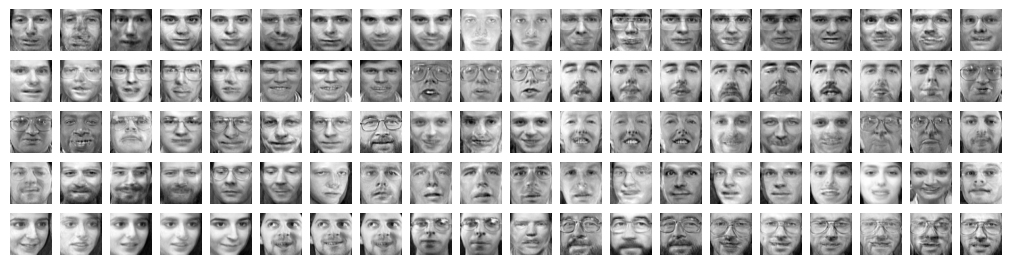

In [69]:
X_samples = pca.inverse_transform(gauss.sample(n_samples=100)[0])
plot_pics(5, 20, X_samples)
plt.show()

Create some noise to add to 50 pictures and plotting them:

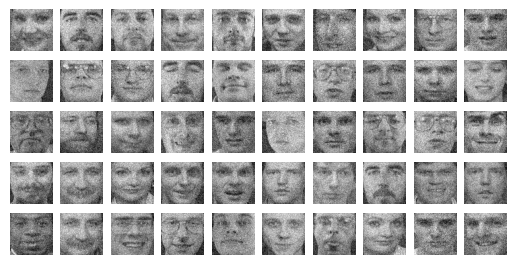

In [70]:
noise = np.random.default_rng(seed=42).standard_normal((50, 64*64)) / 10
X_train_noisy = X_train[:50] + noise
plot_pics(5, 10, X_train_noisy)
plt.show()

See scores of normal data samples:

In [71]:
gauss.score_samples(X_train_reduced[:50])

array([1123.3625, 1131.0615, 1150.1375, 1151.2354, 1115.4904, 1123.3625,
       1116.8065, 1135.5215, 1151.2354, 1095.5386, 1173.472 , 1165.4052,
       1160.8884, 1131.0615, 1165.4052, 1095.8488, 1151.8411, 1115.4904,
       1137.1235, 1166.724 , 1153.056 , 1143.8544, 1108.9486, 1108.9486,
       1095.5385, 1135.9001, 1095.8489, 1150.1375, 1151.8411, 1095.8488,
       1143.8544, 1108.9486, 1174.403 , 1095.5385, 1136.2156, 1152.2102,
       1116.8065, 1131.0616, 1152.8379, 1152.2102, 1160.3915, 1108.9486,
       1095.5385, 1101.2623, 1135.5215, 1151.2354, 1175.12  , 1174.403 ,
       1095.5385, 1095.8488], dtype=float32)

See scores of anomaly samples:

In [72]:
gauss.score_samples(pca.transform(X_train_noisy))

array([ -994640.98956216,  -960557.85230717,  -970752.88795405,
       -1065649.82695839, -1243387.65810253, -1003535.6014376 ,
        -787912.91854249, -1028258.87409741,  -938281.90898819,
        -810684.02229574,  -893782.98607967, -1039834.16726171,
        -950346.68470167, -1075265.26175932,  -940665.94882985,
       -1040770.71892799,  -953426.06195647, -1039139.75592572,
        -859526.1034484 , -1018141.98903669,  -942599.14401512,
       -1082110.50611651,  -961912.08228484,  -905775.73115418,
        -964829.90471621,  -965540.78403458,  -988522.91898556,
        -980947.89884035,  -992365.09245777, -1035121.90384306,
        -900456.2157538 ,  -923660.46615994,  -866531.20510737,
        -905683.7713675 ,  -977553.61257079, -1128673.27079341,
        -881868.6062526 , -1036771.67192671,  -981454.78398998,
       -1059066.77699537,  -983823.72488723,  -963936.89361068,
        -810964.90556907,  -977256.66328394,  -979157.79476571,
       -1066551.26034739, -1140809.15379

The gaussian mixture model could detect the anomalies alright. Anomaly scores are very negative.

## 13. 
Some dimensionality reduction techniques can also be used for
anomaly detection. For example, take the Olivetti faces dataset and
reduce it with PCA, preserving 99% of the variance. Then compute the
reconstruction error for each image. Next, take some of the modified
images you built in the previous exercise and look at their
reconstruction error: notice how much larger it is. If you plot a
reconstructed image, you will see why: it tries to reconstruct a normal
face.

The pca algorithm used earlier preserves 99% variance so I will just reuse it.

Reconstruction error of first 50 normal data samples (root mean square error) in X_train:

In [73]:
normal_error = np.sqrt(np.mean((X_train[:50] - pca.inverse_transform(X_train_reduced[:50]))**2))
print(normal_error)

0.013932918


In [74]:
X_train_noisy_reconstructed = pca.inverse_transform(pca.transform(X_train_noisy))
noisy_error = np.sqrt(np.mean((X_train_noisy - X_train_noisy_reconstructed)**2))
print(noisy_error)

0.09871973752994116


In [75]:
print(f"Noisy error is {(noisy_error / normal_error).round(2)} times bigger than normal error") 

Noisy error is 7.09 times bigger than normal error


In [76]:
def plot_pics(n_row, n_col, X, subfig, title):
    # plt.figure(figsize=(0.64*n_col, 0.64*n_row))
    subfig.suptitle(title)
    axs = subfig.subplots(n_row,n_col)
    for idx, x in enumerate(X):
        ax = axs.flat[idx]
        ax.imshow(x.reshape(64,64), cmap=plt.cm.gray)
        ax.axis("off")

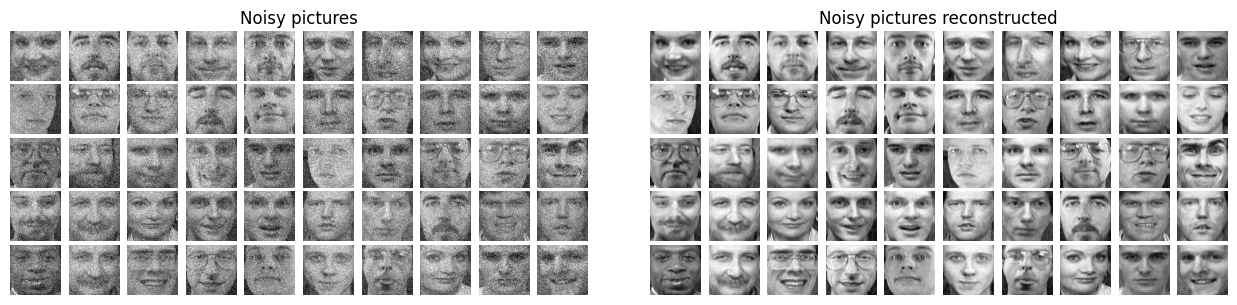

In [77]:
fig = plt.figure(figsize=(20*0.64, 5*0.64))
subfigs = fig.subfigures(1,2)
plot_pics(5, 10, X_train_noisy, subfigs[0], "Noisy pictures")
plot_pics(5, 10, X_train_noisy_reconstructed, subfigs[1], "Noisy pictures reconstructed")
plt.tight_layout(pad=2, w_pad=-5, h_pad=0.3)
plt.show()

The recostruction error of the noisy images is way bigger but, when they are reconstruced, they are less noisy.